我們可以打造很多個分類器，讓他們對一樣本進行預測並取得到最多分類器預測出的類別作為輸出。這種觀念稱為多數決。我們之前所做的隨機森林就是這樣的例子。多數決有兩種實作方法:

1. 使用不同的分類演算法(ex. 3個SVM+5個lr+2個決策樹)
2. 都用同一種演算法，但把數據集切割，製作出不同模型。

利用高中數學就可以證明多數決會比單一模型還要準確(見課本p217-219)。
利用方法1所造的多數決分類器可以用下列的數學式子進行分析。假設$C_j$代表第$j$個分類器，$\mathbf{x}$代表某一筆資料，$C_j(\mathbf{x})$代表$C_j$所預測出$\mathbf{x}$的類別，記為$C_j(\mathbf{x})=i$，$w_j$代表其權重，$\chi_A(\cdot)$代表其特徵函數(characteristic function)，其輸出為一機率值。則預測之結果$\hat{y}$為 $$\hat{y}=\arg\max_i\sum_{j=1}^{m}w_j\chi_A(C_j(x)=i)$$

其中$\chi_A(C_j(x)=i)$亦可寫為$p_{ij}$，指的是第$j$個分類器預測$\mathbf{x}$屬於類別$i$的機率。

可怕的是，scikit learn並沒有這個功能。我們必須自己手刻一個出來。

In [1]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator


class MajorityVoteClassifier(BaseEstimator, 
                             ClassifierMixin):
    """ A majority vote ensemble classifier

    Parameters
    ----------
    classifiers : array-like, shape = [n_classifiers]
      Different classifiers for the ensemble

    vote : str, {'classlabel', 'probability'} (default='label')
      If 'classlabel' the prediction is based on the argmax of
        class labels. Else if 'probability', the argmax of
        the sum of probabilities is used to predict the class label
        (recommended for calibrated classifiers).

    weights : array-like, shape = [n_classifiers], optional (default=None)
      If a list of `int` or `float` values are provided, the classifiers
      are weighted by importance; Uses uniform weights if `weights=None`.

    """
    def __init__(self, classifiers, vote='classlabel', weights=None):

        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value
                                  in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """ Fit classifiers.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Matrix of training samples.

        y : array-like, shape = [n_samples]
            Vector of target class labels.

        Returns
        -------
        self : object

        """
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError("vote must be 'probability' or 'classlabel'"
                             "; got (vote=%r)"
                             % self.vote)

        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError('Number of classifiers and weights must be equal'
                             '; got %d weights, %d classifiers'
                             % (len(self.weights), len(self.classifiers)))

        # Use LabelEncoder to ensure class labels start with 0, which
        # is important for np.argmax call in self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        """ Predict class labels for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Matrix of training samples.

        Returns
        ----------
        maj_vote : array-like, shape = [n_samples]
            Predicted class labels.
            
        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel' vote

            #  Collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X)
                                      for clf in self.classifiers_]).T

            maj_vote = np.apply_along_axis(
                                      lambda x:
                                      np.argmax(np.bincount(x,
                                                weights=self.weights)),
                                      axis=1,
                                      arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        """ Predict class probabilities for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.

        Returns
        ----------
        avg_proba : array-like, shape = [n_samples, n_classes]
            Weighted average probability for each class per sample.

        """
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        """ Get classifier parameter names for GridSearch"""
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' % (name, key)] = value
            return out

D:\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


我們使用鳶尾花數據集來對多數決原理進行測試。為了簡單起見，我們只使用兩個特徵與兩個類別。

In [2]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

# 訓練集與測試集各占一半
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1,stratify=y)

我們訓練三個分類器，分別是邏輯斯回歸，決策數以及KNN。並先用10折交叉驗證法評估他們的個別性能。

In [5]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

clf1 = LogisticRegression(penalty='l2', C=0.001, random_state=1, solver='lbfgs', multi_class='ovr')

clf2 = DecisionTreeClassifier(max_depth=1,
                              criterion='entropy',
                              random_state=0)

clf3 = KNeighborsClassifier(n_neighbors=1,
                            p=2,
                            metric='minkowski')

pipe1 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf3]])

clf_labels = ['Logistic regression', 'Decision tree', 'KNN']

print('10-fold cross validation:\n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

10-fold cross validation:

ROC AUC: 0.87 (+/- 0.17) [Logistic regression]
ROC AUC: 0.89 (+/- 0.16) [Decision tree]
ROC AUC: 0.88 (+/- 0.15) [KNN]


接著，我們利用自己手刻的多數決機器來整合三個模型

In [6]:
# Majority Rule (hard) Voting

mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3]) # 整合三個模型

clf_labels += ['Majority voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train,y=y_train,cv=10,scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

ROC AUC: 0.87 (+/- 0.17) [Logistic regression]
ROC AUC: 0.89 (+/- 0.16) [Decision tree]
ROC AUC: 0.88 (+/- 0.15) [KNN]
ROC AUC: 0.94 (+/- 0.13) [Majority voting]


從結果可以看見整合過的模型正確率達到94%，比其他模型高出5%以上。接下來，我們要繪製ROC曲線以檢查多數決機器對沒見過的數據是否也能產生良好效果。

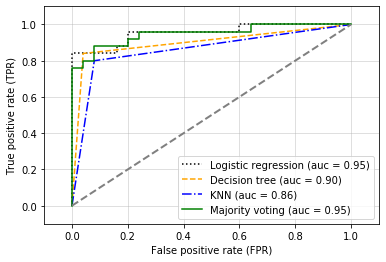

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls \
        in zip(all_clf,
               clf_labels, colors, linestyles):

    # assuming the label of the positive class is 1
    y_pred = clf.fit(X_train,
                     y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test,
                                     y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr,
             color=clr,
             linestyle=ls,
             label='%s (auc = %0.2f)' % (label, roc_auc))

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
         linestyle='--',
         color='gray',
         linewidth=2)

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')


#plt.savefig('images/07_04', dpi=300)
plt.show()

多數決模型的AUC值(複習p206)也是最高的，代表他在這4種模型裡最為理想。但為何邏輯斯回歸也表現不錯呢?可能是因為數據集樣本數目小所導致的高變異。接下來，我們來繪製這四個模型的決策邊界。

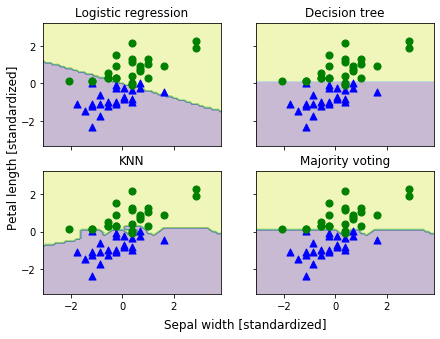

In [12]:
from itertools import product

# 標準化數據集
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)

all_clf = [pipe1, clf2, pipe3, mv_clf] # 所有分類器所形成的串列

# 繪圖區
x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=2, ncols=2, 
                        sharex='col', 
                        sharey='row', 
                        figsize=(7, 5))

for idx, clf, tt in zip(product([0, 1], [0, 1]), # 要畫四張圖
                        all_clf,     # 所有分類器都要畫
                        clf_labels): 
    clf.fit(X_train_std, y_train)
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
    
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0], 
                                  X_train_std[y_train==0, 1], 
                                  c='blue', 
                                  marker='^',
                                  s=50)
    
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0], 
                                  X_train_std[y_train==1, 1], 
                                  c='green', 
                                  marker='o',
                                  s=50)
    
    axarr[idx[0], idx[1]].set_title(tt)

plt.text(-3.5, -5., 
         s='Sepal width [standardized]', 
         ha='center', va='center', fontsize=12)
plt.text(-12.5, 4.5, 
         s='Petal length [standardized]', 
         ha='center', va='center', 
         fontsize=12, rotation=90)

#plt.savefig('images/07_05', dpi=300)
plt.show()

利用網格搜尋來調整決策樹的深度以及邏輯斯回歸中的$C$值。我們分別給了2以及3個候選值，因此一共有6種組合。

In [14]:
from sklearn.model_selection import GridSearchCV

params = {'decisiontreeclassifier__max_depth': [1, 2],
          'pipeline-1__clf__C': [0.001, 0.1, 100.0]}

grid = GridSearchCV(estimator=mv_clf,
                    param_grid=params,
                    cv=10,
                    scoring='roc_auc')
grid.fit(X_train, y_train)

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
          % (grid.cv_results_['mean_test_score'][r], 
             grid.cv_results_['std_test_score'][r] / 2.0, 
             grid.cv_results_['params'][r]))

0.933 +/- 0.07 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.947 +/- 0.07 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
0.973 +/- 0.04 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.947 +/- 0.07 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.947 +/- 0.07 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
0.973 +/- 0.04 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}


D:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [15]:
print('Best parameters: %s' % grid.best_params_) # 輸出最佳組合
print('Accuracy: %.2f' % grid.best_score_) # 輸出最佳組合下所得的正確率

Best parameters: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
Accuracy: 0.97


最後，順便一提，我們在自製的多數決演算法裡寫了個超方便的功能get_params()，那就是能夠查看每個參加多數決的模型的各個參數。

In [13]:
mv_clf.get_params()

{'pipeline-1': Pipeline(memory=None,
          steps=[('sc',
                  StandardScaler(copy=True, with_mean=True, with_std=True)),
                 ['clf',
                  LogisticRegression(C=0.001, class_weight=None, dual=False,
                                     fit_intercept=True, intercept_scaling=1,
                                     l1_ratio=None, max_iter=100,
                                     multi_class='ovr', n_jobs=None,
                                     penalty='l2', random_state=1,
                                     solver='lbfgs', tol=0.0001, verbose=0,
                                     warm_start=False)]],
          verbose=False),
 'decisiontreeclassifier': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
                        max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
            